In [1]:
import pandas as pd
import gc
import matplotlib.pyplot as plt

### Load data

In [2]:
# Load CSV
df = pd.read_csv('../data/cleaned_for_eda.csv')
print(f"Loaded {len(df):,} rows\n")

Loaded 38,074,228 rows



# Exploratory data analysis

In [3]:
# Rating distribution
print("Rating Distribution:")
rating_dist = df['rating'].value_counts().sort_index()
rating_dist_table = pd.DataFrame({'Count': rating_dist,
                                  'Percentage': (rating_dist / len(df) * 100).round(2)
                                 })
print(rating_dist_table)
print()

# Text length distribution
text_length = df['text'].fillna('').str.len()
word_count = df['text'].fillna('').str.split().str.len()
print("Text Length Statistics:")
text_dist_table = pd.DataFrame({'text_length': text_length,
                                'word_count': word_count
                               }).describe().round(2)
print(text_dist_table)
print()

# Reviews per business
print("Reviews per Business:")
business_counts = df['gmap_id'].value_counts()
print(business_counts.describe().round(2))
print()

# Reviews per user
print("Reviews per User:")
user_counts = df['user_id'].value_counts()
print(user_counts.describe().round(2))
print()

del rating_dist, rating_dist_table, text_length, word_count, business_counts, user_counts, text_dist_table
gc.collect()

Rating Distribution:
           Count  Percentage
rating                      
1.0      3314230        8.70
2.0      1340273        3.52
3.0      2699038        7.09
4.0      6366070       16.72
5.0     24354617       63.97

Text Length Statistics:
       text_length   word_count
count  38074228.00  38074228.00
mean        146.63        26.67
std         221.06        41.25
min           0.00         0.00
25%          34.00         6.00
50%          76.00        13.00
75%         172.00        31.00
max       13057.00      1840.00

Reviews per Business:
count    504404.00
mean         75.48
std         197.63
min           1.00
25%           7.00
50%          20.00
75%          67.00
max        9998.00
Name: count, dtype: float64

Reviews per User:
count    9944619.00
mean           3.83
std           11.55
min            1.00
25%            1.00
50%            1.00
75%            2.00
max         1477.00
Name: count, dtype: float64



0

In [4]:
# Average text/word length by rating
print("Text Characteristics by Rating:")
text_stats = pd.DataFrame({'avg_text_length': df.groupby('rating')['text'].apply(lambda x: x.fillna('').str.len().mean()),
                           'avg_word_count': df.groupby('rating')['text'].apply(lambda x: x.fillna('').str.split().str.len().mean())
                          }).round(2)
print(text_stats)

del text_stats
gc.collect()

Text Characteristics by Rating:
        avg_text_length  avg_word_count
rating                                 
1.0              307.52           57.89
2.0              228.78           42.75
3.0              147.75           27.35
4.0              119.42           21.62
5.0              127.20           22.78


0

In [5]:
# Businesses with 10+ reviews
business_counts = df['gmap_id'].value_counts()
businesses_10plus = (business_counts >= 10).sum()
reviews_from_10plus = business_counts[business_counts >= 10].sum()

print("Business Review Thresholds:")
print(f"Businesses with 10+ reviews: {businesses_10plus:,} ({businesses_10plus/len(business_counts)*100:.2f}%)")
print(f"Reviews from those businesses: {reviews_from_10plus:,} ({reviews_from_10plus/len(df)*100:.2f}%)")
print()

# Users with 5+ and 3+ reviews
user_counts = df['user_id'].value_counts()
users_5plus = (user_counts >= 5).sum()
users_3plus = (user_counts >= 3).sum()
reviews_from_5plus = user_counts[user_counts >= 5].sum()
reviews_from_3plus = user_counts[user_counts >= 3].sum()

print("User Review Thresholds:")
print(f"Unique users: {len(user_counts):,}")
print(f"Users with 5+ reviews: {users_5plus:,} ({users_5plus/len(user_counts)*100:.2f}%)")
print(f"Reviews from those users: {reviews_from_5plus:,} ({reviews_from_5plus/len(df)*100:.2f}%)")
print(f"Users with 3+ reviews: {users_3plus:,} ({users_3plus/len(user_counts)*100:.2f}%)")
print(f"Reviews from those users: {reviews_from_3plus:,} ({reviews_from_3plus/len(df)*100:.2f}%)")

del business_counts, user_counts
gc.collect()

Business Review Thresholds:
Businesses with 10+ reviews: 334,187 (66.25%)
Reviews from those businesses: 37,284,174 (97.92%)

User Review Thresholds:
Unique users: 9,944,619
Users with 5+ reviews: 1,444,280 (14.52%)
Reviews from those users: 25,883,160 (67.98%)
Users with 3+ reviews: 2,405,238 (24.19%)
Reviews from those users: 29,116,927 (76.47%)


0

Average Rating by Category (Top 20):
                                                    mean    count
category                                                         
['Mexican restaurant']                              4.26  872,784
['Shopping mall']                                   4.28  783,112
['Hotel']                                           4.07  591,775
['Park', 'Tourist attraction']                      4.50  569,660
['Fast food restaurant', 'Breakfast restaurant'...  3.39  537,137
['Restaurant']                                      4.31  436,777
['Coffee shop', 'Breakfast restaurant', 'Cafe',...  3.99  341,586
['Fast food restaurant', 'Breakfast restaurant'...  3.74  268,329
['Mexican restaurant', 'Restaurant']                4.28  254,216
['Diner', 'American restaurant', 'Breakfast res...  3.81  222,512
['Hamburger restaurant', 'American restaurant',...  4.56  208,652
['Grocery store']                                   4.15  199,134
['Gas station']                        

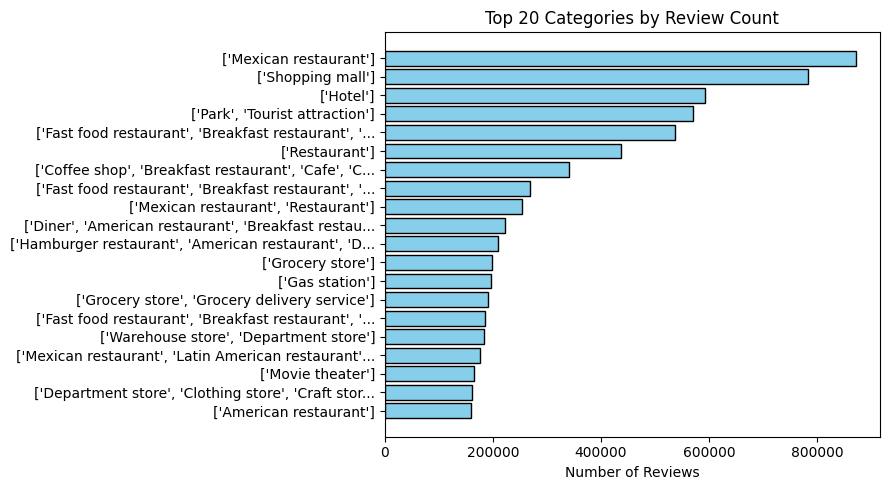

6101

In [6]:
# Average rating by category (top 20)
print("Average Rating by Category (Top 20):")
cat_ratings = df.groupby('category')['rating'].agg(['mean', 'count']).sort_values('count', ascending=False).head(20).round(2)
cat_ratings['count'] = cat_ratings['count'].astype(int).apply(lambda x: f'{x:,}')
print(cat_ratings)
print()

# Top 20 Categories
cat_counts = df['category'].value_counts().head(20)

# Shorten category names for readability
cat_labels = [str(c)[:50] + '...' if len(str(c)) > 50 else str(c) for c in cat_counts.index]

plt.figure(figsize=(9, 5))
plt.barh(range(len(cat_counts)), cat_counts.values, color='skyblue', edgecolor='black')
plt.yticks(range(len(cat_counts)), cat_labels)
plt.xlabel('Number of Reviews')
plt.title('Top 20 Categories by Review Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

del cat_counts, cat_labels
gc.collect()

In [7]:
# Reviews by year
df_time = pd.to_datetime(df['time'], unit='ms')
print("Reviews by Year:")
year_counts = df_time.dt.year.value_counts().sort_index()
year_counts.index = year_counts.index.astype(int)
year_counts = year_counts.apply(lambda x: f'{x:,}')
print(year_counts)
print()

# Average rating by year
rating_by_year = df.groupby(df_time.dt.year)['rating'].mean().round(2)
print("\nAverage Rating by Year:")
print(rating_by_year)

del df_time, year_counts, rating_by_year
gc.collect()

Reviews by Year:
time
1990           183
1999             2
2002             4
2003            34
2004           242
2005           450
2006           538
2007           789
2008         1,513
2009         2,726
2010        13,838
2011        31,653
2012        93,475
2013       204,149
2014       301,824
2015       642,787
2016     2,202,538
2017     5,492,579
2018     8,800,607
2019    10,362,009
2020     6,769,864
2021     3,152,424
Name: count, dtype: str


Average Rating by Year:
time
1990    4.14
1999    4.50
2002    4.25
2003    3.82
2004    3.93
2005    3.86
2006    3.98
2007    3.87
2008    3.79
2009    3.71
2010    3.91
2011    3.93
2012    4.13
2013    4.07
2014    4.07
2015    4.03
2016    4.11
2017    4.18
2018    4.23
2019    4.27
2020    4.28
2021    4.31
Name: rating, dtype: float64


0

User Rating vs Business Avg Rating Correlation:
            rating  avg_rating
rating        1.00        0.38
avg_rating    0.38        1.00



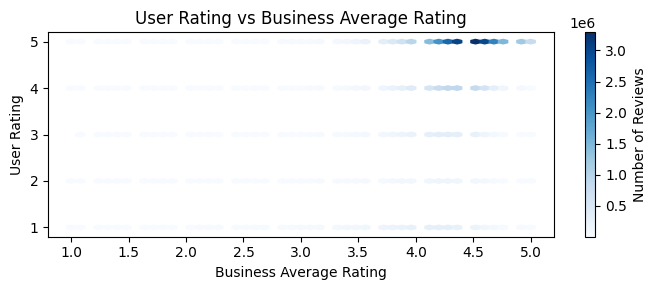

In [8]:
# User rating vs business avg_rating correlation
print("User Rating vs Business Avg Rating Correlation:")
print(df[['rating', 'avg_rating']].corr().round(2))
print()

# Scatter plot: User rating vs Business avg_rating
plt.figure(figsize=(7, 3))
plt.hexbin(df['avg_rating'], df['rating'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Number of Reviews')
plt.xlabel('Business Average Rating')
plt.ylabel('User Rating')
plt.title('User Rating vs Business Average Rating')
plt.tight_layout()
plt.show()

In [9]:
# OUTLIERS

# Text length outliers
text_length = df['text'].fillna('').str.len()
word_count = df['text'].fillna('').str.split().str.len()

print("Text Length Outliers:")
print(f"Reviews with 1000+ characters: {(text_length > 1000).sum():,} ({(text_length > 1000).sum()/len(df)*100:.2f}%)")
print(f"Reviews with 2000+ characters: {(text_length > 2000).sum():,} ({(text_length > 2000).sum()/len(df)*100:.2f}%)")
print(f"Reviews with 5000+ characters: {(text_length > 5000).sum():,} ({(text_length > 5000).sum()/len(df)*100:.2f}%)")
print()

# Business review count outliers
business_counts = df['gmap_id'].value_counts()
print("Business Review Count Outliers:")
print(f"Businesses with 1000+ reviews: {(business_counts >= 1000).sum():,}")
print(f"Businesses with 5000+ reviews: {(business_counts >= 5000).sum():,}")
print(f"Max reviews for one business: {business_counts.max():,}")
print()

# User review count outliers
user_counts = df['user_id'].value_counts()
print("User Review Count Outliers:")
print(f"Users with 100+ reviews: {(user_counts >= 100).sum():,}")
print(f"Users with 500+ reviews: {(user_counts >= 500).sum():,}")
print(f"Max reviews by one user: {user_counts.max():,}")
print()

# Unusual timestamps
df_time = pd.to_datetime(df['time'], unit='ms')
print("Timestamp Outliers:")
print(f"Reviews before 2010: {(df_time.dt.year < 2010).sum():,} ({(df_time.dt.year < 2010).sum()/len(df)*100:.2f}%)")
print(f"Reviews after 2021: {(df_time.dt.year > 2021).sum():,} ({(df_time.dt.year > 2021).sum()/len(df)*100:.2f}%)")

del text_length, word_count, business_counts, user_counts, df_time
gc.collect()

Text Length Outliers:
Reviews with 1000+ characters: 417,518 (1.10%)
Reviews with 2000+ characters: 66,849 (0.18%)
Reviews with 5000+ characters: 235 (0.00%)

Business Review Count Outliers:
Businesses with 1000+ reviews: 2,920
Businesses with 5000+ reviews: 86
Max reviews for one business: 9,998

User Review Count Outliers:
Users with 100+ reviews: 24,938
Users with 500+ reviews: 199
Max reviews by one user: 1,477

Timestamp Outliers:
Reviews before 2010: 6,481 (0.02%)
Reviews after 2021: 0 (0.00%)


0

## Initial EDA takeaways

- Reviews are heavily skewed positive (64% are 5-stars)
- Negative reviews (1-2 stars) are longer than positive ones, likely people write more when they're upset  
- Big increase in reviews from 2016-2019, in 2020 covid is likely the cause of drop and 2021 is incomplete  
- Most users are one-time reviewers (median = 1 review)
- heavy users are the bulk of reviews with 15% of users writing 69% of all reviews  
- Fast food chains generally get lower ratings (3.4-3.7) compared to while sit-down restaurants, parks and malls (4.2-4.5)  
- Users tend to rate slightly higher than business averages, unsure what that means for sure  
- Long reviews and heavy users are rare - only 0.18% of reviews are extremely long (2000+ chars) and heavy active users (500+ reviews) are less than 200  

## EDA for modeling

In [10]:
# Review distributions 

# Count reviews per user and per business
user_review_counts = df['user_id'].value_counts()
business_review_counts = df['gmap_id'].value_counts()


print("Reviewer distributions:")

# Thresholds for reviewers
reviewer_thresholds = [1, 2, 3, 5, 10, 25, 50, 100, 250, 500]

print(f"\n{'Min Reviews':<15} {'Users':<15} {'% of Users':<15} {'Total Reviews':<15} {'% of Reviews':<15}")
print("-" * 70)

for threshold in reviewer_thresholds:
    users_above = (user_review_counts >= threshold).sum()
    pct_users = (users_above / len(user_review_counts)) * 100
    
    reviews_from_these_users = user_review_counts[user_review_counts >= threshold].sum()
    pct_reviews = (reviews_from_these_users / len(df)) * 100
    
    print(f"{threshold}+ reviews{'':<5} {users_above:<15,} {pct_users:<15.2f} {reviews_from_these_users:<15,} {pct_reviews:<15.2f}")

print()
print("Business review distribution:")

# Thresholds for businesses
business_thresholds = [1, 3, 5, 10, 25, 50, 100, 500, 1000]

print(f"\n{'Min Reviews':<15} {'Businesses':<15} {'% of Businesses':<15} {'Total Reviews':<15} {'% of Reviews':<15}")
print("-" * 70)

for threshold in business_thresholds:
    businesses_above = (business_review_counts >= threshold).sum()
    pct_businesses = (businesses_above / len(business_review_counts)) * 100
    
    reviews_from_these_biz = business_review_counts[business_review_counts >= threshold].sum()
    pct_reviews = (reviews_from_these_biz / len(df)) * 100
    
    print(f"{threshold}+ reviews{'':<5} {businesses_above:<15,} {pct_businesses:<15.2f} {reviews_from_these_biz:<15,} {pct_reviews:<15.2f}")

Reviewer distributions:

Min Reviews     Users           % of Users      Total Reviews   % of Reviews   
----------------------------------------------------------------------
1+ reviews      9,944,619       100.00          38,074,228      100.00         
2+ reviews      3,823,158       38.44           31,952,767      83.92          
3+ reviews      2,405,238       24.19           29,116,927      76.47          
5+ reviews      1,444,280       14.52           25,883,160      67.98          
10+ reviews      733,591         7.38            21,272,989      55.87          
25+ reviews      257,680         2.59            14,165,213      37.20          
50+ reviews      93,253          0.94            8,584,575       22.55          
100+ reviews      24,938          0.25            3,979,394       10.45          
250+ reviews      2,295           0.02            794,189         2.09           
500+ reviews      199             0.00            128,048         0.34           

Business revie

### Notes

- We should filter for reviewers with 3+ or 5+ reviews to get the most consistent training data. Users will less reviews are more prone to leaving bad or good reviews based on outlier experiences. Previous professor mentioned filtering for users with 5+ reviews was common industry practice. Would still retain 26 million reviews. 
- Consider filtering extremely high counts such as 250+ or 500+, could be spam users. Could even be stricter at 100+.
- We should filter for businesses with 10+ or 25+ reviews. Would retain ~95% of data and would small outliers.
- High review count businesses are likely okay.

In [11]:
# Reviews by year

df_time = pd.to_datetime(df['time'], unit='ms')
print("Reviews by Year:")
year_counts = df_time.dt.year.value_counts().sort_index()
year_counts.index = year_counts.index.astype(int)
year_counts = year_counts.apply(lambda x: f'{x:,}')
print(year_counts)

Reviews by Year:
time
1990           183
1999             2
2002             4
2003            34
2004           242
2005           450
2006           538
2007           789
2008         1,513
2009         2,726
2010        13,838
2011        31,653
2012        93,475
2013       204,149
2014       301,824
2015       642,787
2016     2,202,538
2017     5,492,579
2018     8,800,607
2019    10,362,009
2020     6,769,864
2021     3,152,424
Name: count, dtype: str


### Notes
- Google business reviews launched in 2007. Google reviews added pictures to reviews in 2016. Google reviews surpassed facebook as the largest number of consumer reviews in 2017.
- Filter reviews before 2007, maybe 2011 (analyze 10 years of data).
- Reviews grow 5x from 2015-2016. Might consider from 2016-2021 as this is the bulk of the reviews. 

In [12]:
# Category analysis

print("Catergories:")
# Count reviews per category
category_counts = df['category'].value_counts()

print(f"\nTotal unique categories: {len(category_counts):,}")
print(f"Total reviews: {len(df):,}\n")

# Show only top 20 categories
print(f"{'Category':<50} {'Reviews':<15} {'% of Total':<15}")
print("-" * 80)

for category, count in category_counts.head(20).items():
    pct = (count / len(df)) * 100
    print(f"{str(category)[:48]:<50} {count:<15,} {pct:<15.2f}")

Catergories:

Total unique categories: 86,882
Total reviews: 38,074,228

Category                                           Reviews         % of Total     
--------------------------------------------------------------------------------
['Mexican restaurant']                             872,784         2.29           
['Shopping mall']                                  783,112         2.06           
['Hotel']                                          591,775         1.55           
['Park', 'Tourist attraction']                     569,660         1.50           
['Fast food restaurant', 'Breakfast restaurant',   537,137         1.41           
['Restaurant']                                     436,777         1.15           
['Coffee shop', 'Breakfast restaurant', 'Cafe',    341,586         0.90           
['Fast food restaurant', 'Breakfast restaurant',   268,329         0.70           
['Mexican restaurant', 'Restaurant']               254,216         0.67           
['Diner', 'Ameri